## Imports

In [ ]:
import numpy as np
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR
from tqdm import tqdm

## Blocks

In [ ]:
""" blocks.py
    Neural network blocks.

    Collaboratively developed
    by Avi Schwarzschild, Eitan Borgnia,
    Arpit Bansal, and Zeyad Emam.

    BasicBlocks borrowed from ResNet architechtures
    Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>

    Developed for DeepThinking project
    October 2021
"""

from torch import nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    """Basic residual block class 1D"""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1, group_norm=False):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(4, planes, affine=False) if group_norm else nn.Sequential()
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(4, planes, affine=False) if group_norm else nn.Sequential()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(nn.Conv1d(in_planes, self.expansion * planes,
                                                    kernel_size=1, stride=stride, bias=False))

    def forward(self, x):
        out = F.relu(self.gn1(self.conv1(x)))
        out = self.gn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## Models

In [ ]:
""" dt_net_1d.py
    DeepThinking 1D convolutional neural network.

    Collaboratively developed
    by Avi Schwarzschild, Eitan Borgnia,
    Arpit Bansal, and Zeyad Emam.

    Developed for DeepThinking project
    October 2021
"""

import torch
from torch import nn

# Ignore statemenst for pylint:
#     Too many branches (R0912), Too many statements (R0915), No member (E1101),
#     Not callable (E1102), Invalid name (C0103), No exception (W0702)
# pylint: disable=R0912, R0915, E1101, E1102, C0103, W0702, R0914


class DTNet1D(nn.Module):
    """DeepThinking 1D Network model class"""

    def __init__(self, block, num_blocks, width, recall, group_norm=False, **kwargs):
        super().__init__()

        self.width = int(width)
        self.recall = recall
        self.group_norm = group_norm

        proj_conv = nn.Conv1d(1, width, kernel_size=3,
                              stride=1, padding=1, bias=False)

        conv_recall = nn.Conv1d(width + 1, width, kernel_size=3,
                                stride=1, padding=1, bias=False)

        if self.recall:
            recur_layers = [conv_recall, nn.ReLU()]
        else:
            recur_layers = []

        for i in range(len(num_blocks)):
            recur_layers.append(self._make_layer(block, width, num_blocks[i], stride=1))

        head_conv1 = nn.Conv1d(width, width, kernel_size=3,
                               stride=1, padding=1, bias=False)
        head_conv2 = nn.Conv1d(width, int(width/2), kernel_size=3,
                               stride=1, padding=1, bias=False)
        head_conv3 = nn.Conv1d(int(width/2), 2, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.projection = nn.Sequential(proj_conv, nn.ReLU())
        self.recur_block = nn.Sequential(*recur_layers)
        self.head = nn.Sequential(head_conv1, nn.ReLU(),
                                  head_conv2, nn.ReLU(),
                                  head_conv3)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for strd in strides:
            layers.append(block(self.width, planes, strd, self.group_norm))
            self.width = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, iters_to_do, interim_thought=None, **kwargs):
        initial_thought = self.projection(x)

        if interim_thought is None:
            interim_thought = initial_thought

        all_outputs = torch.zeros((x.size(0), iters_to_do, 2, x.size(2))).to(x.device)

        for i in range(iters_to_do):
            if self.recall:
                interim_thought = torch.cat([interim_thought, x], 1)

            interim_thought = self.recur_block(interim_thought)
            out = self.head(interim_thought)
            all_outputs[:, i] = out

        if self.training:
            return out, interim_thought

        return all_outputs


def dt_net_1d(width, **kwargs):
    return DTNet1D(BasicBlock, [2], width, recall=False)


def dt_net_recall_1d(width, **kwargs):
    return DTNet1D(BasicBlock, [2], width, recall=True)


def dt_net_gn_1d(width, **kwargs):
    return DTNet1D(BasicBlock, [2], width, recall=False, group_norm=True)


def dt_net_recall_gn_1d(width, **kwargs):
    return DTNet1D(BasicBlock, [2], width, recall=True, group_norm=True)







class FeedForwardNet1D(nn.Module):
    """Modified Residual Network model class"""

    def __init__(self, block, num_blocks, width, recall, max_iters=8, group_norm=False):
        super().__init__()

        self.width = int(width)
        self.recall = recall
        self.group_norm = group_norm

        proj_conv = nn.Conv1d(1, width, kernel_size=3, stride=1, padding=1, bias=False)

        if self.recall:
            self.recall_layer = nn.Conv1d(width + 1, width, kernel_size=3,
                                          stride=1, padding=1, bias=False)
        else:
            self.recall_layer = nn.Sequential()

        self.feedforward_layers = nn.ModuleList()
        for _ in range(max_iters):
            internal_block = []
            for j in range(len(num_blocks)):
                internal_block.append(self._make_layer(block, width, num_blocks[j], stride=1))
            self.feedforward_layers.append(nn.Sequential(*internal_block))

        head_conv1 = nn.Conv1d(width, width, kernel_size=3, stride=1, padding=1, bias=False)
        head_conv2 = nn.Conv1d(width, int(width/2), kernel_size=3, stride=1, padding=1, bias=False)
        head_conv3 = nn.Conv1d(int(width/2), 2, kernel_size=3, stride=1, padding=1, bias=False)

        self.iters = max_iters
        self.projection = nn.Sequential(proj_conv, nn.ReLU())
        self.head = nn.Sequential(head_conv1, nn.ReLU(), head_conv2, nn.ReLU(), head_conv3)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for strd in strides:
            layers.append(block(self.width, planes, strd, self.group_norm))
            self.width = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, iters_to_do, interim_thought=None, iters_elapsed=0, **kwargs):
        assert (iters_elapsed + iters_to_do) <= self.iters
        initial_thought = self.projection(x)

        if interim_thought is None:
            interim_thought = initial_thought

        all_outputs = torch.zeros((x.size(0), iters_to_do, 2, x.size(2))).to(x.device)

        for i, layer in enumerate(self.feedforward_layers[iters_elapsed:iters_elapsed+iters_to_do]):
            if self.recall:
                interim_thought = torch.cat([interim_thought, x], 1)
                interim_thought = self.recall_layer(interim_thought)
            interim_thought = layer(interim_thought)
            out = self.head(interim_thought)
            all_outputs[:, i] = out

        if self.training:
            return out, interim_thought

        return all_outputs


def feedforward_net_1d(width, **kwargs):
    return FeedForwardNet1D(BasicBlock, [2], width, recall=False, max_iters=kwargs["max_iters"])


def feedforward_net_recall_1d(width, **kwargs):
    return FeedForwardNet1D(BasicBlock, [2], width, recall=True, max_iters=kwargs["max_iters"])


def feedforward_net_gn_1d(width, **kwargs):
    return FeedForwardNet1D(BasicBlock, [2], width, recall=False, max_iters=kwargs["max_iters"], group_norm=True)


def feedforward_net_recall_gn_1d(width, **kwargs):
    return FeedForwardNet1D(BasicBlock, [2], width, recall=True, max_iters=kwargs["max_iters"], group_norm=True)

## Dataset

In [ ]:
# Custom code

import torch
from torch.utils import data

class ComparisonDataset(torch.utils.data.Dataset):
    
    def __init__(self, num_digits: int = 32, num_samples: int = int(1e4)):
        
        self.inputs = torch.rand(num_samples, num_digits) - 0.5
        
        # new code
        self.inputs = self.inputs.view(self.inputs.size(0), 1, -1)
        
        self.targets = self.inputs < self.inputs[:, :, 0:1]
        
    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return self.inputs.size(0)
    
    
    

def prepare_custom_loader(train_batch_size, test_batch_size, train_data, test_data,
                          train_split=0.8, shuffle=True):

    dataset = ComparisonDataset(num_digits=train_data)
    testset = ComparisonDataset(num_digits=test_data)

    train_split = int(train_split * len(dataset))

    trainset, valset = torch.utils.data.random_split(dataset,
                                                     [train_split,
                                                      int(len(dataset) - train_split)],
                                                     generator=torch.Generator().manual_seed(42))

    trainloader = data.DataLoader(trainset, num_workers=0, batch_size=train_batch_size,
                                  shuffle=shuffle, drop_last=True)
    testloader = data.DataLoader(testset, num_workers=0, batch_size=test_batch_size,
                                 shuffle=False, drop_last=False)
    valloader = data.DataLoader(valset, num_workers=0, batch_size=test_batch_size,
                                shuffle=False, drop_last=False)
    loaders = {"train": trainloader, "test": testloader, "val": valloader}

    return loaders

## Warmup

In [ ]:
""" warmup.py
    code for warmup learning rate scheduler
    borrowed from https://github.com/ArneNx/pytorch_warmup/tree/warmup_fix
    and modified July 2020
"""

import math
from torch.optim import Optimizer

# Ignore statemenst for pylint:
#     Too many branches (R0912), Too many statements (R0915), No member (E1101),
#     Not callable (E1102), Invalid name (C0103), No exception (W0702),
#     Too many local variables (R0914).
# pylint: disable=R0912, R0915, E1101, E1102, C0103, W0702, R0914


class BaseWarmup:
    """Base class for all warmup schedules

    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_params (list): warmup paramters
        last_step (int): The index of last step. (Default: -1)
        warmup_period (int or list): Warmup period
    """

    def __init__(self, optimizer, warmup_params, last_step=-1, warmup_period=0):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        self.warmup_params = warmup_params
        self.last_step = last_step
        self.base_lrs = [group['lr'] for group in self.optimizer.param_groups]
        self.warmup_period = warmup_period
        self.dampen()

    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.

        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def dampen(self, step=None):
        """Dampen the learning rates.

        Arguments:
            step (int): The index of current step. (Default: None)
        """
        if step is None:
            step = self.last_step + 1
        self.last_step = step
        if isinstance(self.warmup_period, int) and step < self.warmup_period:
            for i, (group, params) in enumerate(zip(self.optimizer.param_groups,
                                                    self.warmup_params)):
                if isinstance(self.warmup_period, list) and step >= self.warmup_period[i]:
                    continue
                omega = self.warmup_factor(step, **params)
                group['lr'] = omega * self.base_lrs[i]

    def warmup_factor(self, step, warmup_period):
        """Place holder for objects that inherit BaseWarmup."""
        raise NotImplementedError


def get_warmup_params(warmup_period, group_count):
    if type(warmup_period) == list:
        if len(warmup_period) != group_count:
            raise ValueError(
                'size of warmup_period does not equal {}.'.format(group_count))
        for x in warmup_period:
            if type(x) != int:
                raise ValueError(
                    'An element in warmup_period, {}, is not an int.'.format(
                        type(x).__name__))
        warmup_params = [dict(warmup_period=x) for x in warmup_period]
    elif type(warmup_period) == int:
        warmup_params = [dict(warmup_period=warmup_period)
                         for _ in range(group_count)]
    else:
        raise TypeError('{} is not a list nor an int.'.format(
            type(warmup_period).__name__))
    return warmup_params


class ExponentialWarmup(BaseWarmup):
    """Exponential warmup schedule.

    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_period (int or list): Effective warmup period
        last_step (int): The index of last step. (Default: -1)
    """

    def __init__(self, optimizer, warmup_period, last_step=-1):
        group_count = len(optimizer.param_groups)
        warmup_params = get_warmup_params(warmup_period, group_count)
        super().__init__(optimizer, warmup_params, last_step, warmup_period)

    def warmup_factor(self, step, warmup_period):
        if step + 1 >= warmup_period:
            return 1.0
        else:
            return 1.0 - math.exp(-(step+1) / warmup_period)


## Train Model

#### Hyperparameters

In [ ]:
# Progress:
# so far, using train_batch_size = 50 seems to be promising.
# training is capping out around 87-90% using batch=50, width = 300 and max_iters = 10
# try tuning learning rate using smaller batch sizes !!!

# Data parameters
problem = "custom"
train_batch_size = 100 # 50 # 20 # 100
test_batch_size = 100 # 500 ?
train_data = 32 # length of sequences for training data
test_data = 128 # 512 # length of sequences for testing data

# Training parameters
alpha = 1
clip = 1
epochs = 150
lr = 0.001 #0.002 # 0.001
lr_decay = "step"
lr_factor = 0.1 # 0.1
lr_schedule = [60, 100] # [70, 100] # [60, 100]
lr_throttle: False # lr_throttle is only needed for mazes.
optimizer_name = "adam"
save_period = -1
test_mode = "default"
train_mode = "progressive"
val_period = 20
warmup_period = 10

# Model parameters
#model: dt_net_recall_1d
#model_path:
width = 400 #300 #200 #400
max_iters = 15 #10 #5 # 30
low = 5
high = 10
test_iterations = list(range(low, high + 1))

#### Main 1. Initialize Data and Network

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

loaders = prepare_custom_loader(train_batch_size= train_batch_size,
                                test_batch_size= test_batch_size,
                                train_data= train_data,
                                test_data= test_data)
    
'''    
net, start_epoch, optimizer_state_dict = load_model_from_checkpoint("custom",
                                                                    "feedforward_net_recall_1d",
                                                                   device)
'''

'''
# FeedForwardNet1D(block = BasicBlock,
                   num_blocks = [2],
                   width = 5,         # analogous to conv1d out_channels
                   recall=True,
                   max_iters=5,       # default is 8
                   group_norm = False # default is False
                   )
'''
# In the prefix sums training, the parameters were width = 400 and max_iters = 30.
net = dt_net_recall_1d(width=width, max_iters=max_iters)
#net = feedforward_net_recall_1d(width=width, max_iters=max_iters)

if torch.cuda.is_available():
    net.cuda()

    
start_epoch = 0

#### Main 2. Initialize optimizer and TrainingSetup

In [ ]:
base_params = [p for n, p in net.named_parameters()]
recur_params = []
all_params = [{"params": base_params}]

if optimizer_name == "adam":
    optimizer = Adam(all_params, lr=lr, weight_decay=2e-4)
elif optimizer_name == "adamw":
    optimizer = AdamW(all_params, lr=lr, weight_decay=2e-4)

warmup_scheduler = ExponentialWarmup(optimizer, warmup_period=warmup_period)


if lr_decay.lower() == "step":
    lr_scheduler = MultiStepLR(optimizer, milestones=lr_schedule,
                               gamma=lr_factor, last_epoch=-1)
elif lr_decay.lower() == "cosine":
    lr_scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1, verbose=False)

#### Main 3. Training

##### Helper Functions

In [ ]:
from random import randrange

def get_output_for_prog_loss(inputs, max_iters, net):
    # get features from n iterations to use as input
    n = randrange(0, max_iters)

    # do k iterations using intermediate features as input
    k = randrange(1, max_iters - n + 1)

    if n > 0:
        _, interim_thought = net(inputs, iters_to_do=n)
        interim_thought = interim_thought.detach()
    else:
        interim_thought = None

    outputs, _ = net(inputs, iters_elapsed=n, iters_to_do=k, interim_thought=interim_thought)
    return outputs, k


def get_predicted(inputs, outputs, problem):
    outputs = outputs.clone()
    predicted = outputs.argmax(1)
    predicted = predicted.view(predicted.size(0), -1)

    return predicted

In [ ]:
def train():

    trainloader = loaders["train"]
    net.train()
    k = 0
    criterion = torch.nn.CrossEntropyLoss(reduction="none")

    train_loss = 0 # total loss for all batches
    correct = 0
    total = 0 
    
    
    # For each batch in this epoch:
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, leave=False)):
        
        # Get the (input data, ideal output) pair
        inputs, targets = inputs.to(device), targets.to(device).long()
        targets = targets.view(targets.size(0), -1)

        optimizer.zero_grad()

        # get fully unrolled loss if alpha is not 1 (if it is 1, this loss term is not used
        # so we save time by setting it equal to 0).
        
        # Get the output from the net
        outputs_max_iters, _ = net(inputs, iters_to_do=max_iters)
        
        if alpha != 1:
            outputs_max_iters = outputs_max_iters.view(outputs_max_iters.size(0),
                                                       outputs_max_iters.size(1), -1)
            loss_max_iters = criterion(outputs_max_iters, targets)
        else:
            # Instantiate the loss_max_iters matrix. If alpha == 1, it will be zero.
            loss_max_iters = torch.zeros_like(targets).float()
            
        # get progressive loss if alpha is not 0 (if it is 0, this loss term is not used
        # so we save time by setting it equal to 0).
        if alpha != 0:
            # Get a new output using interim thoughts
            outputs, k = get_output_for_prog_loss(inputs, max_iters, net)
            outputs = outputs.view(outputs.size(0), outputs.size(1), -1)
            # Calculate the Cross-Entropy loss between the outputs and targets.
            # loss_progressive is a (m x l) Tensor, where m = batch size and l = input length.
            loss_progressive = criterion(outputs, targets)            
        else:
            loss_progressive = torch.zeros_like(targets).float()

        
        # Calculate the mean loss_max_iters. If alpha == 1, it will be zero.
        loss_max_iters_mean = loss_max_iters.mean()
        # Calcualte the mean loss_progressive.
        loss_progressive_mean = loss_progressive.mean()
        
        # Calculate loss. If alpha == 1, then loss = loss_progressive_mean (cross-entropy).
        loss = (1 - alpha) * loss_max_iters_mean + alpha * loss_progressive_mean
        # Backpropagation
        loss.backward()

        # Clipping and gradient descent
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        
        # Add the loss from this batch
        train_loss += loss.item()
        # Get the predicted labels from outputs_max_iters.
        # The outputs are (m x 2 x l) Tensors, where m = batch size and l = input and output length.
        # Thus, the argmax must be taken among dimension 1, so as to get the labels in a (m x l) Tensor.
        predicted = get_predicted(inputs, outputs_max_iters, problem)
        # Calculate the number of samples in the batch where the model predicted all values of the output correctly.
        correct += torch.amin(predicted == targets, dim=[-1]).sum().item()
        # Calculate the number of samples in the batch.
        total += targets.size(0)
    
    
    # Divide the training loss by the number of batches.
    # (the number of batches should be a constant for all epochs)
    train_loss /= (batch_idx + 1)
    acc = 100.0 * correct / total

    lr_scheduler.step()
    warmup_scheduler.dampen()

    return train_loss, acc

In [ ]:
def test_default(testloader, iters):

    net.eval()
    corrects = torch.zeros(max(iters))
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            all_outputs = net(inputs, iters_to_do=max(iters))

            for i in range(all_outputs.size(1)):
                outputs = all_outputs[:, i]
                predicted = get_predicted(inputs, outputs, problem)
                targets = targets.view(targets.size(0), -1)
                corrects[i] += torch.amin(predicted == targets, dim=[1]).sum().item()

            total += targets.size(0)

    accuracy = 100.0 * corrects / total
    ret_acc = {}
    for ite in iters:
        ret_acc[ite] = accuracy[ite-1].item()
        
    
    return ret_acc


def test(loaders, iters):
    accs = []
    for loader in loaders:
        accuracy = test_default(loader, iters)
        accs.append(accuracy)
    return accs

##### Training Function

In [ ]:
highest_val_acc_so_far = -1
best_so_far = False

for epoch in range(start_epoch, epochs):
    
    loss, acc = train()
    
    val_acc = test(loaders=[loaders['val']], iters=[max_iters])[0][max_iters]
    
    if val_acc > highest_val_acc_so_far:
        best_so_far = True
        highest_val_acc_so_far = val_acc
        
    print(f"Training loss at epoch {epoch}: {loss}")
    print(f"Training accuracy at epoch {epoch}: {acc} %")
    print(f"Val accuracy at epoch {epoch}: {val_acc} %")

    # if the loss is nan, then stop the training
    if np.isnan(float(loss)):
        raise ValueError(f"Loss is nan, exiting...")

Training loss at epoch 0: 0.6765937745571137
Training accuracy at epoch 0: 0.6875 %
Val accuracy at epoch 0: 0.550000011920929 %


Training loss at epoch 1: 0.5458389773964882
Training accuracy at epoch 1: 1.05 %
Val accuracy at epoch 1: 1.600000023841858 %


Training loss at epoch 2: 0.5122340228408575
Training accuracy at epoch 2: 1.7375 %
Val accuracy at epoch 2: 3.549999952316284 %


Training loss at epoch 3: 0.671327679976821
Training accuracy at epoch 3: 1.925 %
Val accuracy at epoch 3: 3.1500000953674316 %


Training loss at epoch 4: 5.221056091785431
Training accuracy at epoch 4: 2.2375 %
Val accuracy at epoch 4: 3.25 %


Training loss at epoch 5: 0.4029355779290199
Training accuracy at epoch 5: 5.1 %
Val accuracy at epoch 5: 4.849999904632568 %


Training loss at epoch 6: 0.9923521194607019
Training accuracy at epoch 6: 7.575 %
Val accuracy at epoch 6: 4.650000095367432 %


Training loss at epoch 7: 0.27362811993807556
Training accuracy at epoch 7: 12.45 %
Val accuracy at epoch 7: 4.599999904632568 %


Training loss at epoch 8: 0.3225976384244859
Training accuracy at epoch 8: 12.5125 %
Val accuracy at epoch 8: 13.699999809265137 %


Training loss at epoch 9: 0.3000276699662209
Training accuracy at epoch 9: 10.5375 %
Val accuracy at epoch 9: 9.100000381469727 %


Training loss at epoch 10: 0.22150981612503529
Training accuracy at epoch 10: 16.75 %
Val accuracy at epoch 10: 20.75 %


Training loss at epoch 11: 0.2139340686611831
Training accuracy at epoch 11: 18.0875 %
Val accuracy at epoch 11: 21.25 %


Training loss at epoch 12: 0.19209968410432338
Training accuracy at epoch 12: 21.3625 %
Val accuracy at epoch 12: 14.949999809265137 %


Training loss at epoch 13: 0.1998593846336007
Training accuracy at epoch 13: 21.1 %
Val accuracy at epoch 13: 33.75 %


Training loss at epoch 14: 0.16924521094188094
Training accuracy at epoch 14: 27.775 %
Val accuracy at epoch 14: 34.75 %


Training loss at epoch 15: 0.18739646612666547
Training accuracy at epoch 15: 25.65 %
Val accuracy at epoch 15: 33.25 %


Training loss at epoch 16: 0.2425218576565385
Training accuracy at epoch 16: 26.1 %
Val accuracy at epoch 16: 33.45000076293945 %


Training loss at epoch 17: 0.15478154537267982
Training accuracy at epoch 17: 31.4875 %
Val accuracy at epoch 17: 36.70000076293945 %


Training loss at epoch 18: 0.14533013980835677
Training accuracy at epoch 18: 32.9125 %
Val accuracy at epoch 18: 45.900001525878906 %


Training loss at epoch 19: 0.12615245068445802
Training accuracy at epoch 19: 35.6 %
Val accuracy at epoch 19: 34.70000076293945 %


Training loss at epoch 20: 0.1218386469874531
Training accuracy at epoch 20: 38.7875 %
Val accuracy at epoch 20: 44.29999923706055 %


Training loss at epoch 21: 0.150220948131755
Training accuracy at epoch 21: 33.925 %
Val accuracy at epoch 21: 53.900001525878906 %


Training loss at epoch 22: 0.12116643781773746
Training accuracy at epoch 22: 39.1875 %
Val accuracy at epoch 22: 35.5 %


Training loss at epoch 23: 0.13520306763239204
Training accuracy at epoch 23: 35.325 %
Val accuracy at epoch 23: 42.20000076293945 %


Training loss at epoch 24: 0.12973831170238553
Training accuracy at epoch 24: 41.15 %
Val accuracy at epoch 24: 29.350000381469727 %


Training loss at epoch 25: 0.11833578632213175
Training accuracy at epoch 25: 39.5125 %
Val accuracy at epoch 25: 24.5 %


Training loss at epoch 26: 0.1039896299596876
Training accuracy at epoch 26: 40.925 %
Val accuracy at epoch 26: 61.29999923706055 %


Training loss at epoch 27: 0.13923848196864128
Training accuracy at epoch 27: 36.4375 %
Val accuracy at epoch 27: 42.400001525878906 %


Training loss at epoch 28: 0.10467323251068592
Training accuracy at epoch 28: 47.025 %
Val accuracy at epoch 28: 39.20000076293945 %


Training loss at epoch 29: 0.11732697878032923
Training accuracy at epoch 29: 38.4 %
Val accuracy at epoch 29: 41.25 %


Training loss at epoch 30: 0.09178148899227381
Training accuracy at epoch 30: 43.8375 %
Val accuracy at epoch 30: 37.75 %


Training loss at epoch 31: 0.10243732002563774
Training accuracy at epoch 31: 41.3875 %
Val accuracy at epoch 31: 34.400001525878906 %


Training loss at epoch 32: 0.09913258566521108
Training accuracy at epoch 32: 42.5875 %
Val accuracy at epoch 32: 43.650001525878906 %


Training loss at epoch 33: 0.11412010141648352
Training accuracy at epoch 33: 39.5125 %
Val accuracy at epoch 33: 52.849998474121094 %


Training loss at epoch 34: 0.07913375315256417
Training accuracy at epoch 34: 50.3875 %
Val accuracy at epoch 34: 27.25 %


Training loss at epoch 35: 0.08414907092228532
Training accuracy at epoch 35: 46.775 %
Val accuracy at epoch 35: 49.0 %


Training loss at epoch 36: 0.09151731238234788
Training accuracy at epoch 36: 53.3625 %
Val accuracy at epoch 36: 41.45000076293945 %


Training loss at epoch 37: 0.08740658680908382
Training accuracy at epoch 37: 41.8875 %
Val accuracy at epoch 37: 33.650001525878906 %


Training loss at epoch 38: 0.09987448556348681
Training accuracy at epoch 38: 44.1875 %
Val accuracy at epoch 38: 40.54999923706055 %


Training loss at epoch 39: 0.08323324960656464
Training accuracy at epoch 39: 45.4875 %
Val accuracy at epoch 39: 31.049999237060547 %


Training loss at epoch 40: 0.10795601932331919
Training accuracy at epoch 40: 43.0125 %
Val accuracy at epoch 40: 14.850000381469727 %


Training loss at epoch 41: 0.11893736622296273
Training accuracy at epoch 41: 37.0875 %
Val accuracy at epoch 41: 37.400001525878906 %


Training loss at epoch 42: 0.10180251346901059
Training accuracy at epoch 42: 46.25 %
Val accuracy at epoch 42: 37.150001525878906 %


Training loss at epoch 43: 0.08508922862820327
Training accuracy at epoch 43: 46.4625 %
Val accuracy at epoch 43: 47.75 %


Training loss at epoch 44: 0.08297685640864075
Training accuracy at epoch 44: 49.2 %
Val accuracy at epoch 44: 45.04999923706055 %


Training loss at epoch 45: 0.07395500482525677
Training accuracy at epoch 45: 51.3125 %
Val accuracy at epoch 45: 29.600000381469727 %


Training loss at epoch 46: 0.08263560237828642
Training accuracy at epoch 46: 47.6375 %
Val accuracy at epoch 46: 31.899999618530273 %


Training loss at epoch 47: 0.11383420603815467
Training accuracy at epoch 47: 46.4625 %
Val accuracy at epoch 47: 42.95000076293945 %


Training loss at epoch 48: 0.08647595210932195
Training accuracy at epoch 48: 51.5375 %
Val accuracy at epoch 48: 32.79999923706055 %


Training loss at epoch 49: 0.07989635453559459
Training accuracy at epoch 49: 51.225 %
Val accuracy at epoch 49: 50.650001525878906 %


Training loss at epoch 50: 0.08342279866337776
Training accuracy at epoch 50: 47.625 %
Val accuracy at epoch 50: 58.900001525878906 %


Training loss at epoch 51: 0.08848062395118177
Training accuracy at epoch 51: 49.275 %
Val accuracy at epoch 51: 34.25 %


Training loss at epoch 52: 0.07979568650480359
Training accuracy at epoch 52: 51.7375 %
Val accuracy at epoch 52: 43.349998474121094 %


Training loss at epoch 53: 0.07199378681834787
Training accuracy at epoch 53: 51.2375 %
Val accuracy at epoch 53: 42.099998474121094 %


Training loss at epoch 54: 0.07516041216440499
Training accuracy at epoch 54: 51.3875 %
Val accuracy at epoch 54: 49.75 %


Training loss at epoch 55: 0.07532027761917562
Training accuracy at epoch 55: 55.4375 %
Val accuracy at epoch 55: 58.650001525878906 %


Training loss at epoch 56: 0.07703651757910848
Training accuracy at epoch 56: 50.4875 %
Val accuracy at epoch 56: 43.150001525878906 %


Training loss at epoch 57: 0.09265201734378933
Training accuracy at epoch 57: 50.0 %
Val accuracy at epoch 57: 53.95000076293945 %


Training loss at epoch 58: 0.08646133940201253
Training accuracy at epoch 58: 45.35 %
Val accuracy at epoch 58: 48.20000076293945 %


Training loss at epoch 59: 0.07323468369431793
Training accuracy at epoch 59: 48.4 %
Val accuracy at epoch 59: 35.70000076293945 %


Training loss at epoch 60: 0.0414125552168116
Training accuracy at epoch 60: 72.4 %
Val accuracy at epoch 60: 81.19999694824219 %


Training loss at epoch 61: 0.043142072844784704
Training accuracy at epoch 61: 79.725 %
Val accuracy at epoch 61: 81.25 %


Training loss at epoch 62: 0.041990909317974
Training accuracy at epoch 62: 77.35 %
Val accuracy at epoch 62: 81.05000305175781 %


Training loss at epoch 63: 0.03686346341855824
Training accuracy at epoch 63: 81.0375 %
Val accuracy at epoch 63: 79.4000015258789 %


Training loss at epoch 64: 0.039459892688319086
Training accuracy at epoch 64: 80.7625 %
Val accuracy at epoch 64: 80.8499984741211 %


Training loss at epoch 65: 0.02962446209276095
Training accuracy at epoch 65: 82.0 %
Val accuracy at epoch 65: 81.05000305175781 %


Training loss at epoch 66: 0.019688530103303493
Training accuracy at epoch 66: 80.75 %
Val accuracy at epoch 66: 79.9000015258789 %


Training loss at epoch 67: 0.0309860133449547
Training accuracy at epoch 67: 81.2 %
Val accuracy at epoch 67: 75.44999694824219 %


Training loss at epoch 68: 0.03440477764233947
Training accuracy at epoch 68: 80.05 %
Val accuracy at epoch 68: 83.80000305175781 %


Training loss at epoch 69: 0.0286774959997274
Training accuracy at epoch 69: 83.575 %
Val accuracy at epoch 69: 84.1500015258789 %


Training loss at epoch 70: 0.02258496799040586
Training accuracy at epoch 70: 83.45 %
Val accuracy at epoch 70: 87.30000305175781 %


Training loss at epoch 71: 0.02659379784599878
Training accuracy at epoch 71: 85.7625 %
Val accuracy at epoch 71: 87.1500015258789 %


Training loss at epoch 72: 0.03023418810334988
Training accuracy at epoch 72: 85.9625 %
Val accuracy at epoch 72: 79.9000015258789 %


Training loss at epoch 73: 0.04417595152044669
Training accuracy at epoch 73: 85.3375 %
Val accuracy at epoch 73: 80.0 %


Training loss at epoch 74: 0.027265181537950413
Training accuracy at epoch 74: 84.425 %
Val accuracy at epoch 74: 79.6500015258789 %


Training loss at epoch 75: 0.02425282644107938
Training accuracy at epoch 75: 84.575 %
Val accuracy at epoch 75: 84.55000305175781 %


Training loss at epoch 76: 0.02392975374823436
Training accuracy at epoch 76: 85.3875 %
Val accuracy at epoch 76: 85.80000305175781 %


Training loss at epoch 77: 0.038099055888596925
Training accuracy at epoch 77: 83.775 %
Val accuracy at epoch 77: 86.94999694824219 %


Training loss at epoch 78: 0.027319210092537106
Training accuracy at epoch 78: 83.85 %
Val accuracy at epoch 78: 87.05000305175781 %


Training loss at epoch 79: 0.03196470849215984
Training accuracy at epoch 79: 87.1125 %
Val accuracy at epoch 79: 85.94999694824219 %


Training loss at epoch 80: 0.024526982096722348
Training accuracy at epoch 80: 85.7875 %
Val accuracy at epoch 80: 83.4000015258789 %


Training loss at epoch 81: 0.03306156810140237
Training accuracy at epoch 81: 85.3375 %
Val accuracy at epoch 81: 83.8499984741211 %


Training loss at epoch 82: 0.030423500522738324
Training accuracy at epoch 82: 85.45 %
Val accuracy at epoch 82: 79.75 %


Training loss at epoch 83: 0.028912608610698953
Training accuracy at epoch 83: 87.1 %
Val accuracy at epoch 83: 81.0999984741211 %


Training loss at epoch 84: 0.03121847889269702
Training accuracy at epoch 84: 85.1 %
Val accuracy at epoch 84: 84.55000305175781 %


Training loss at epoch 85: 0.029781394312158226
Training accuracy at epoch 85: 87.4125 %
Val accuracy at epoch 85: 87.69999694824219 %


Training loss at epoch 86: 0.03498282661894336
Training accuracy at epoch 86: 84.175 %
Val accuracy at epoch 86: 85.25 %


Training loss at epoch 87: 0.02621031811577268
Training accuracy at epoch 87: 81.15 %
Val accuracy at epoch 87: 66.5999984741211 %


Training loss at epoch 88: 0.029060915822628885
Training accuracy at epoch 88: 82.2875 %
Val accuracy at epoch 88: 84.1500015258789 %


Training loss at epoch 89: 0.025023644138127566
Training accuracy at epoch 89: 85.15 %
Val accuracy at epoch 89: 80.69999694824219 %


Training loss at epoch 90: 0.03408213431830518
Training accuracy at epoch 90: 85.3625 %
Val accuracy at epoch 90: 78.8499984741211 %


Training loss at epoch 91: 0.03635178721160628
Training accuracy at epoch 91: 84.575 %
Val accuracy at epoch 91: 86.44999694824219 %


Training loss at epoch 92: 0.042230017244582994
Training accuracy at epoch 92: 83.85 %
Val accuracy at epoch 92: 81.55000305175781 %


Training loss at epoch 93: 0.03384242327883839
Training accuracy at epoch 93: 85.475 %
Val accuracy at epoch 93: 85.8499984741211 %


Training loss at epoch 94: 0.03282192516489886
Training accuracy at epoch 94: 80.625 %
Val accuracy at epoch 94: 81.9000015258789 %


Training loss at epoch 95: 0.029310036048991607
Training accuracy at epoch 95: 85.2125 %
Val accuracy at epoch 95: 86.44999694824219 %


Training loss at epoch 96: 0.03402702297898941
Training accuracy at epoch 96: 84.7625 %
Val accuracy at epoch 96: 84.6500015258789 %


Training loss at epoch 97: 0.026112125150393694
Training accuracy at epoch 97: 81.4625 %
Val accuracy at epoch 97: 86.1500015258789 %


Training loss at epoch 98: 0.03089819452143274
Training accuracy at epoch 98: 85.275 %
Val accuracy at epoch 98: 77.3499984741211 %


Training loss at epoch 99: 0.02221195020247251
Training accuracy at epoch 99: 84.9625 %
Val accuracy at epoch 99: 83.55000305175781 %


Training loss at epoch 100: 0.014665100857382641
Training accuracy at epoch 100: 91.05 %
Val accuracy at epoch 100: 89.55000305175781 %


Training loss at epoch 101: 0.02795499886851758
Training accuracy at epoch 101: 92.275 %
Val accuracy at epoch 101: 89.0 %


Training loss at epoch 102: 0.020441936195129528
Training accuracy at epoch 102: 93.0 %
Val accuracy at epoch 102: 89.5999984741211 %


Training loss at epoch 103: 0.02624929548765067
Training accuracy at epoch 103: 93.3875 %
Val accuracy at epoch 103: 88.9000015258789 %


Training loss at epoch 104: 0.013903098963783122
Training accuracy at epoch 104: 92.4125 %
Val accuracy at epoch 104: 88.5999984741211 %


Training loss at epoch 105: 0.016952241299441083
Training accuracy at epoch 105: 93.1625 %
Val accuracy at epoch 105: 85.8499984741211 %


Training loss at epoch 106: 0.02339639057754539
Training accuracy at epoch 106: 93.0625 %
Val accuracy at epoch 106: 89.6500015258789 %


Training loss at epoch 107: 0.026014603511430322
Training accuracy at epoch 107: 93.6 %
Val accuracy at epoch 107: 89.44999694824219 %


Training loss at epoch 108: 0.02885778201452922
Training accuracy at epoch 108: 93.4625 %
Val accuracy at epoch 108: 88.9000015258789 %


Training loss at epoch 109: 0.017292771831853314
Training accuracy at epoch 109: 93.575 %
Val accuracy at epoch 109: 89.0999984741211 %


Training loss at epoch 110: 0.017293296527350323
Training accuracy at epoch 110: 93.7125 %
Val accuracy at epoch 110: 89.8499984741211 %


Training loss at epoch 111: 0.016887679221690634
Training accuracy at epoch 111: 93.475 %
Val accuracy at epoch 111: 89.5 %


Training loss at epoch 112: 0.03124331025464926
Training accuracy at epoch 112: 93.4125 %
Val accuracy at epoch 112: 89.0 %


Training loss at epoch 113: 0.02709523242956493
Training accuracy at epoch 113: 93.4375 %
Val accuracy at epoch 113: 89.6500015258789 %


Training loss at epoch 114: 0.025312345108250155
Training accuracy at epoch 114: 93.6125 %
Val accuracy at epoch 114: 89.69999694824219 %


Training loss at epoch 115: 0.013620476637152023
Training accuracy at epoch 115: 93.8375 %
Val accuracy at epoch 115: 89.0999984741211 %


Training loss at epoch 116: 0.028278189492993988
Training accuracy at epoch 116: 93.7 %
Val accuracy at epoch 116: 88.05000305175781 %


Training loss at epoch 117: 0.018633750310982578
Training accuracy at epoch 117: 93.775 %
Val accuracy at epoch 117: 88.5999984741211 %


Training loss at epoch 118: 0.015376701211789624
Training accuracy at epoch 118: 93.4125 %
Val accuracy at epoch 118: 87.8499984741211 %


Training loss at epoch 119: 0.019512246997328474
Training accuracy at epoch 119: 93.4625 %
Val accuracy at epoch 119: 87.6500015258789 %


Training loss at epoch 120: 0.025705592462327332
Training accuracy at epoch 120: 93.75 %
Val accuracy at epoch 120: 89.75 %


Training loss at epoch 121: 0.03058111410646234
Training accuracy at epoch 121: 94.3875 %
Val accuracy at epoch 121: 89.19999694824219 %


Training loss at epoch 122: 0.021019731237902305
Training accuracy at epoch 122: 93.9125 %
Val accuracy at epoch 122: 89.5 %


Training loss at epoch 123: 0.02779513626883272
Training accuracy at epoch 123: 93.6625 %
Val accuracy at epoch 123: 89.6500015258789 %


Training loss at epoch 124: 0.03057592130789999
Training accuracy at epoch 124: 94.125 %
Val accuracy at epoch 124: 89.0999984741211 %


Training loss at epoch 125: 0.03473579681158299
Training accuracy at epoch 125: 93.7375 %
Val accuracy at epoch 125: 90.19999694824219 %


Training loss at epoch 126: 0.03226839571434539
Training accuracy at epoch 126: 94.275 %
Val accuracy at epoch 126: 90.05000305175781 %


Training loss at epoch 127: 0.02056081579066813
Training accuracy at epoch 127: 94.025 %
Val accuracy at epoch 127: 89.0999984741211 %


Training loss at epoch 128: 0.012493523594457656
Training accuracy at epoch 128: 93.625 %
Val accuracy at epoch 128: 89.44999694824219 %


Training loss at epoch 129: 0.016709517646813766
Training accuracy at epoch 129: 93.975 %
Val accuracy at epoch 129: 89.0999984741211 %


Training loss at epoch 130: 0.019783219503005968
Training accuracy at epoch 130: 94.25 %
Val accuracy at epoch 130: 89.75 %


Training loss at epoch 131: 0.023076800446142444
Training accuracy at epoch 131: 94.1125 %
Val accuracy at epoch 131: 89.5999984741211 %


Training loss at epoch 132: 0.016910199285484852
Training accuracy at epoch 132: 93.9625 %
Val accuracy at epoch 132: 89.55000305175781 %


Training loss at epoch 133: 0.035669367120135576
Training accuracy at epoch 133: 94.275 %
Val accuracy at epoch 133: 89.3499984741211 %


Training loss at epoch 134: 0.03468662542873062
Training accuracy at epoch 134: 93.9375 %
Val accuracy at epoch 134: 89.1500015258789 %


Training loss at epoch 135: 0.017700527084525675
Training accuracy at epoch 135: 93.9625 %
Val accuracy at epoch 135: 89.1500015258789 %


Training loss at epoch 136: 0.04524903432757128
Training accuracy at epoch 136: 94.5 %
Val accuracy at epoch 136: 90.25 %


Training loss at epoch 137: 0.03825597698742058
Training accuracy at epoch 137: 94.5375 %
Val accuracy at epoch 137: 90.05000305175781 %


Training loss at epoch 138: 0.008665647750603966
Training accuracy at epoch 138: 93.95 %
Val accuracy at epoch 138: 89.6500015258789 %


Training loss at epoch 139: 0.02857062154216692
Training accuracy at epoch 139: 94.6875 %
Val accuracy at epoch 139: 89.6500015258789 %


Training loss at epoch 140: 0.020791678220848552
Training accuracy at epoch 140: 94.375 %
Val accuracy at epoch 140: 89.5 %


Training loss at epoch 141: 0.01868420593527844
Training accuracy at epoch 141: 94.525 %
Val accuracy at epoch 141: 89.94999694824219 %


Training loss at epoch 142: 0.01348666287085507
Training accuracy at epoch 142: 94.75 %
Val accuracy at epoch 142: 89.4000015258789 %


Training loss at epoch 143: 0.02610473606036976
Training accuracy at epoch 143: 94.0125 %
Val accuracy at epoch 143: 88.94999694824219 %


Training loss at epoch 144: 0.02025099564198172
Training accuracy at epoch 144: 94.625 %
Val accuracy at epoch 144: 89.8499984741211 %


Training loss at epoch 145: 0.021027435126597993
Training accuracy at epoch 145: 94.6125 %
Val accuracy at epoch 145: 89.25 %


Training loss at epoch 146: 0.02964972564514028
Training accuracy at epoch 146: 93.7625 %
Val accuracy at epoch 146: 89.6500015258789 %


Training loss at epoch 147: 0.03438395654084161
Training accuracy at epoch 147: 93.575 %
Val accuracy at epoch 147: 88.30000305175781 %


Training loss at epoch 148: 0.02416774545854423
Training accuracy at epoch 148: 93.8375 %
Val accuracy at epoch 148: 90.05000305175781 %


Training loss at epoch 149: 0.014049235731363297
Training accuracy at epoch 149: 94.4375 %
Val accuracy at epoch 149: 88.55000305175781 %


In [ ]:
torch.save(net, 'weights_final.pt')

## Main 4. Testing

In [ ]:
'''
test_acc, val_acc, train_acc = test(net,
                                    [loaders["test"], loaders["val"], loaders["train"]],
                                    test_mode,
                                    [5],
                                    problem,
                                    device)
''';

test_acc, val_acc, train_acc = test([loaders['test'], loaders['val'], loaders['train']], np.arange(0, 200, 10) + max_iters)

print(f"Training accuracy: {train_acc}")
print(f"Val accuracy: {val_acc}")
print(f"Testing accuracy (hard data): {test_acc}")


Training accuracy: {15: 93.4375, 25: 90.75, 35: 88.19999694824219, 45: 86.69999694824219, 55: 86.0, 65: 85.5374984741211, 75: 85.2125015258789, 85: 84.9625015258789, 95: 84.82499694824219, 105: 84.7125015258789, 115: 84.625, 125: 84.5875015258789, 135: 84.5625, 145: 84.55000305175781, 155: 84.5250015258789, 165: 84.5, 175: 84.44999694824219, 185: 84.4375, 195: 84.4375, 205: 84.42500305175781}
Val accuracy: {15: 88.55000305175781, 25: 87.4000015258789, 35: 85.3499984741211, 45: 84.6500015258789, 55: 83.5999984741211, 65: 83.19999694824219, 75: 82.9000015258789, 85: 82.8499984741211, 95: 82.69999694824219, 105: 82.69999694824219, 115: 82.55000305175781, 125: 82.55000305175781, 135: 82.55000305175781, 145: 82.5, 155: 82.5, 165: 82.5, 175: 82.5, 185: 82.5, 195: 82.44999694824219, 205: 82.44999694824219}
Testing accuracy (hard data): {15: 0.0, 25: 0.5899999737739563, 35: 8.930000305175781, 45: 14.329999923706055, 55: 16.200000762939453, 65: 16.940000534057617, 75: 17.1200008392334, 85: 17.2

In [ ]:
import pickle

with open('data.pickle', 'wb') as file:
  pickle.dump([test_acc, val_acc, train_acc], file)

UnpicklingError: ignored

#### Visualization

In [ ]:
net = torch.load('weights_final.pt')

In [ ]:
#for inputs, targets in loaders['train']:
for inputs, targets in loaders['test']:
  inputs, targets = inputs.to(device), targets.to(device)
  break

inputs.shape, targets.shape

(torch.Size([100, 1, 128]), torch.Size([100, 1, 128]))

In [ ]:
#outputs = net(inputs, iters_to_do=max_iters)
outputs = net(inputs, iters_to_do=50)

In [ ]:
i = 3

inputs[i][0][0]

tensor(-0.0787, device='cuda:0')

In [ ]:
m = torch.nn.Softmax(dim=1)

Text(0, 0.5, 'Vector Index')

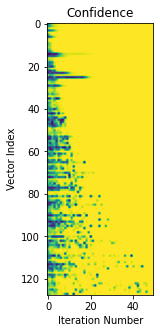

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5,5))
plt.imshow(m(outputs[i]).detach().cpu().numpy().max(axis=1).T)
plt.title('Confidence')
plt.xlabel('Iteration Number')
plt.ylabel('Vector Index')

Text(0, 0.5, 'Vector Index')

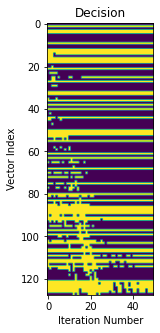

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(m(outputs[i]).argmax(dim=1).cpu().numpy().T)

plt.title('Decision')
plt.xlabel('Iteration Number')
plt.ylabel('Vector Index')

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(targets[i].cpu().numpy().T)
plt.axis('off')

(-0.5, 0.5, 127.5, -0.5)

In [ ]:
m(outputs[i]).argmax(dim=1)[-1] == targets[i][0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],

In [ ]:
targets[i].sum()

tensor(51, device='cuda:0')